In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook
import scipy.stats as sstats
import math

import seaborn as sns
from sklearn import datasets

# Zadanie 1. (2 punkty)
Zaimplementuj (w dowolnym języku programowania) algorytm APRIORI do generowania reguł asocjacyjnych. Sprawdź działanie algorytmu na wybranych przez siebie danych (sztucznie wygenerowanych prostych danych testowych oraz wybranych przez siebie danych pochodzących z UCI Machine Learning Repository).

In [2]:
test_df = pd.read_csv("test_data.dat",header = None)
test_df[0] = test_df[0].map(lambda s: set(map(int,s.split(' '))))
test_df.head()

,0
0,"{1, 2, 3}"
1,"{2, 3}"
2,{2}
3,"{1, 2}"
4,{1}


In [3]:
def rule(X,Y):
    return (X,Y)

In [4]:
def supp(df,X):
    return np.mean(df[0].map(lambda s: X.issubset(s)))

In [5]:
def supp_of_rule(df,X):
    return np.mean(df[0].map(lambda s: (X[0] | X[1]).issubset(s)))

In [6]:
def conf(df,X):
    return supp_of_rule(df,X) / supp(df,X[0])

In [7]:
supp(test_df,{2,3})

0.25

In [8]:
supp_of_rule(test_df,rule({2,3},{1}))

0.03571428571428571

In [9]:
conf(test_df,rule({2},{3}))

0.7

In [10]:
def frequent_sets(df,min_supp,max_p = None):
    if not max_p:
        max_p = np.max(df[0].map(max))
    supports = [0] * (max_p+1)
    N = df.shape[0]
    for t in df[0]:
        for p in t:
            supports[p] += 1
            
    L1 = []
    for i in range(1,max_p+1):
        if supports[i] >= N*min_supp:
            L1.append({i})
        
    #prods = list(map(lambda i: set([i]),range(1,np.max(df[0].map(max))+1)))
    L = [L1]
    #L.append(list(filter(lambda s: supp(df,s) >= min_supp ,prods)))
    while L[-1]:
        Lk = L[-1]
        k = len(Lk[0])
        print(f"   k = {k}")
        Ck = []
        for i in range(len(Lk)):
            for j in range(i+1,len(Lk)):
                c = Lk[i] | Lk[j]
                if len(c) == k+1:
                    Ck.append(c)
        supps = [0] * len(Ck)
        
        for t in df[0]:
            for i,c in enumerate(Ck):
                if c.issubset(t):
                    supps[i] += 1
        
        Lk_1 = []
        for i,sup in enumerate(supps):
            if sup >= N*min_supp:
                Lk_1.append(Ck[i])
        L.append(Lk_1)
        #L.append(list(filter(lambda s: supp(df,s) >= min_supp ,Ck)))
    return [s for ls in L for s in ls]

In [11]:
freq_sets = frequent_sets(test_df,0.25)
freq_sets

   k = 1
   k = 2


[{2}, {3}, {5}, {2, 3}]

In [12]:
def apriori(df,min_supp,min_conf,max_p = None):
    print("Generating frequent sets")
    freq_sets = frequent_sets(df,min_supp,max_p)
    print("Frequent sets generated")
    S = []
    S.append(list(map(lambda s: rule(s,set()),freq_sets)))
    print("Generating rules")
    while S[-1]:
        print(f"   k = {len(S)}")
        Sk = S[-1]
        Sk_1 = []
        for r in Sk:
            if len(r[0]) > 1:
                for e in r[0]:
                    A,B = r[0].copy(),r[1].copy()
                    A.remove(e)
                    B.add(e)
                    new_rule = rule(A,B)
                    if conf(df,new_rule) >= min_conf and (not new_rule in Sk_1):
                        Sk_1.append(new_rule)
        S.append(Sk_1)
    return [r for lr in S[1:] for r in lr]

In [13]:
rules = apriori(test_df,0.25,0.25)
rules

Generating frequent sets
   k = 1
   k = 2
Frequent sets generated
Generating rules
   k = 1
   k = 2


[({3}, {2}), ({2}, {3})]

In [14]:
def lift(df,rule):
    return conf(df,rule)/supp(df,rule[1])

In [15]:
def leverage(df,rule):
    return supp_of_rule(df,rule) - supp(df,rule[0])*supp(df,rule[1])

In [16]:
def print_rules_info(rules,df,k=None,n=3,key = 7):
    N = len(rules)
    M = df.shape[0]
    supA = [0] * N
    supB = [0] * N
    supAB = [0] * N
    
    for t in df[0]:
        for i,r in enumerate(rules):
            if r[0].issubset(t):
                supA[i] += 1
            if r[1].issubset(t):
                supB[i] += 1
            if (r[0] | r[1]).issubset(t):
                supAB[i] += 1
    
    res = []
    for i,r in enumerate(rules):
        sA = supA[i]/M
        sB = supB[i]/M
        sAB = supAB[i]/M
        res.append((r[0], r[1], sA, sB, sAB, sAB/sA, sAB/(sA*sB), sAB-(sA*sB)))

    res.sort(key = lambda e: e[key],reverse=True)
    
    if not k:
        k = N
    for r in res[:k]:
        print(f"{r[0]} -> {r[1]}, supp(A): {round(r[2],n)}, supp(B): {round(r[3],n)}, supp(A v B): {round(r[4],n)}, conf: {round(r[5],n)}, lift: {round(r[6],n)}, leverage: {round(r[7],n)}")

In [17]:
print_rules_info(rules,test_df,3)

{3} -> {2}, supp(A): 0.679, supp(B): 0.357, supp(A v B): 0.25, conf: 0.368, lift: 1.032, leverage: 0.008
{2} -> {3}, supp(A): 0.357, supp(B): 0.679, supp(A v B): 0.25, conf: 0.7, lift: 1.032, leverage: 0.008


## Association rules for iris

In [18]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['target'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


sepal length (cm): 

(4 , 4.4] -> 0

(4.4 , 4.8] -> 1

...

(7.6 , 8] -> 9


sepal width (cm):

(1.9 , 2.2] -> 10

(2.2 , 2.5] -> 11

...

(4.6 , 4.9] -> 19


petal length (cm):

(0.9 , 1.5] -> 20

(1.5 , 2.1] -> 21

...

(6.3 , 6.9] -> 29

petal width (cm):

(0.0 , 0.25] -> 30

(0.25 , 0.5] -> 31

...

(2.25 , 2.5] -> 39


target:

0 -> 40

1 -> 41

2 -> 42

In [19]:
def code(sample):
    sl = sample['sepal length (cm)']
    sl = int((sl - 4) // 0.4001)
    sw = sample['sepal width (cm)']
    sw = int((sw - 1.9) // 0.3001 + 10)
    pl = sample['petal length (cm)']
    pl = int((pl - 0.9) // 0.6001 + 20)
    pw = sample['petal width (cm)']
    pw = int(pw // 0.25 + 30)
    t = sample['target']
    t = int(t+40)
    return set([sl,sw,pl,pw,t])

In [20]:
def decode(code):
    if code < 10:
        return f"sepal length ({code*0.4 + 4},{(code+1)*0.4 + 4}]"
    elif code < 20:
        code -=10
        return f"sepal width ({code*0.3 + 1.9},{(code+1)*0.3 + 1.9}]"
    elif code < 30:
        code -= 20
        return f"petal length ({code*0.6 + 0.9},{(code+1)*0.6 + 0.9}]"
    elif code < 40:
        code -= 30
        return f"petal width ({code*0.25},{(code+1)*0.25}]"
    else:
        if code == 40:
            return 'setosa'
        if code == 41:
            return 'versicolor'
        return 'virginica'

In [21]:
def print_rules_info_with_decode(rules,df,f,k=None,n=3,key = 7):
    N = len(rules)
    M = df.shape[0]
    supA = [0] * N
    supB = [0] * N
    supAB = [0] * N
    
    for t in df[0]:
        for i,r in enumerate(rules):
            if r[0].issubset(t):
                supA[i] += 1
            if r[1].issubset(t):
                supB[i] += 1
            if (r[0] | r[1]).issubset(t):
                supAB[i] += 1
    
    res = []
    for i,r in enumerate(rules):
        sA = supA[i]/M
        sB = supB[i]/M
        sAB = supAB[i]/M
        A = {f(e) for e in r[0]}
        B = {f(e) for e in r[1]}
        res.append((A, B, sA, sB, sAB, sAB/sA, sAB/(sA*sB), sAB-(sA*sB)))

    res.sort(key = lambda e: e[key],reverse=True)
    
    if not k:
        k = N
    for r in res[:k]:
        print(f"{r[0]} -> {r[1]}, supp(A): {round(r[2],n)}, supp(B): {round(r[3],n)}, supp(A v B): {round(r[4],n)}, conf: {round(r[5],n)}, lift: {round(r[6],n)}, leverage: {round(r[7],n)}")

In [22]:
res = []
for id_ in iris_df.index:
    sample = iris_df.loc[id_]
    res.append(code(sample))
iris_df[0] = res
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,0
0,5.1,3.5,1.4,0.2,0,"{2, 40, 15, 20, 30}"
1,4.9,3.0,1.4,0.2,0,"{2, 40, 13, 20, 30}"
2,4.7,3.2,1.3,0.2,0,"{1, 40, 14, 20, 30}"
3,4.6,3.1,1.5,0.2,0,"{1, 40, 13, 20, 30}"
4,5.0,3.6,1.4,0.2,0,"{2, 40, 15, 20, 30}"


In [23]:
iris_df_ = iris_df.drop(['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','target'], axis=1)
iris_df_

,0
0,"{2, 40, 15, 20, 30}"
1,"{2, 40, 13, 20, 30}"
2,"{1, 40, 14, 20, 30}"
3,"{1, 40, 13, 20, 30}"
4,"{2, 40, 15, 20, 30}"
...,...
145,"{6, 39, 42, 13, 27}"
146,"{37, 5, 42, 11, 26}"
147,"{38, 6, 42, 13, 27}"
148,"{5, 39, 42, 14, 27}"


In [24]:
iris_rules = apriori(iris_df_,0.1,0.1)

Generating frequent sets
   k = 1
   k = 2
   k = 3
Frequent sets generated
Generating rules
   k = 1
   k = 2
   k = 3


In [40]:
print_rules_info_with_decode(iris_rules,iris_df_,decode,key=7,k=10)

{'petal length (0.9,1.5]'} -> {'setosa'}, supp(A): 0.247, supp(B): 0.353, supp(A v B): 0.247, conf: 1.0, lift: 2.83, leverage: 0.16
{'setosa'} -> {'petal length (0.9,1.5]'}, supp(A): 0.353, supp(B): 0.247, supp(A v B): 0.247, conf: 0.698, lift: 2.83, leverage: 0.16
{'petal width (0.0,0.25]'} -> {'setosa'}, supp(A): 0.227, supp(B): 0.353, supp(A v B): 0.227, conf: 1.0, lift: 2.83, leverage: 0.147
{'setosa'} -> {'petal width (0.0,0.25]'}, supp(A): 0.353, supp(B): 0.227, supp(A v B): 0.227, conf: 0.642, lift: 2.83, leverage: 0.147
{'petal width (0.0,0.25]'} -> {'petal length (0.9,1.5]'}, supp(A): 0.227, supp(B): 0.247, supp(A v B): 0.18, conf: 0.794, lift: 3.219, leverage: 0.124
{'petal length (0.9,1.5]'} -> {'petal width (0.0,0.25]'}, supp(A): 0.247, supp(B): 0.227, supp(A v B): 0.18, conf: 0.73, lift: 3.219, leverage: 0.124
{'petal width (0.0,0.25]', 'setosa'} -> {'petal length (0.9,1.5]'}, supp(A): 0.227, supp(B): 0.247, supp(A v B): 0.18, conf: 0.794, lift: 3.219, leverage: 0.124
{'pe

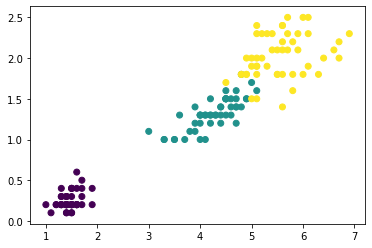

In [26]:
plt.scatter(iris.data[:,2],iris.data[:,3],c=iris.target)

# Zadanie 2. (2 punkty)
Znajdź ciekawe reguły asocjacyjne w zbiorze danych Retail (stworzonym przez Toma Brijsa). Użyj własnej implementacji algorytmu APRIORI lub jego modyfikacji. Uzasadnij dlaczego wskazane reguły uznajesz za ciekawe.

In [27]:
retail_df = pd.read_csv("retail.dat",header = None)
retail_df[0] = retail_df[0].map(lambda s: set(map(int,s[:-1].split(' '))))
retail_df.head()

,0
0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,"{32, 30, 31}"
2,"{33, 34, 35}"
3,"{36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}"
4,"{48, 47, 38, 39}"


In [36]:
retail_rules = apriori(retail_df,0.075,0.15)

Generating frequent sets
   k = 1
   k = 2
   k = 3
Frequent sets generated
Generating rules
   k = 1
   k = 2
   k = 3


In [29]:
print_rules_info(retail_rules,retail_df,k=10)

{39} -> {48}, supp(A): 0.575, supp(B): 0.478, supp(A v B): 0.331, conf: 0.575, lift: 1.203, leverage: 0.056
{48} -> {39}, supp(A): 0.478, supp(B): 0.575, supp(A v B): 0.331, conf: 0.692, lift: 1.203, leverage: 0.056
{39} -> {41}, supp(A): 0.575, supp(B): 0.17, supp(A v B): 0.129, conf: 0.225, lift: 1.329, leverage: 0.032
{41} -> {39}, supp(A): 0.17, supp(B): 0.575, supp(A v B): 0.129, conf: 0.764, lift: 1.329, leverage: 0.032
{48, 39} -> {41}, supp(A): 0.331, supp(B): 0.17, supp(A v B): 0.084, conf: 0.253, lift: 1.491, leverage: 0.028
{41} -> {48, 39}, supp(A): 0.17, supp(B): 0.331, supp(A v B): 0.084, conf: 0.493, lift: 1.491, leverage: 0.028
{48, 41} -> {39}, supp(A): 0.102, supp(B): 0.575, supp(A v B): 0.084, conf: 0.817, lift: 1.421, leverage: 0.025
{41, 39} -> {48}, supp(A): 0.129, supp(B): 0.478, supp(A v B): 0.084, conf: 0.645, lift: 1.35, leverage: 0.022
{48} -> {41, 39}, supp(A): 0.478, supp(B): 0.129, supp(A v B): 0.084, conf: 0.175, lift: 1.35, leverage: 0.022
{41} -> {48}, 

# Zadanie 3. (2 punkty)
Znajdź ciekawe reguły asocjacyjne w zbiorze danych Kosarak (stworzonym przez Ferenca Bodona). Użyj własnej implementacji algorytmu APRIORI lub jego modyfikacji. Uzasadnij dlaczego wskazane reguły uznajesz za ciekawe.

In [37]:
kosarak_df = pd.read_csv("kosarak.dat",header = None)
kosarak_df[0] = kosarak_df[0].map(lambda s: set(map(int,s.split(' '))))
print(kosarak_df.shape)
kosarak_df.head()

(990002, 1)


,0
0,"{1, 2, 3}"
1,{1}
2,"{4, 5, 6, 7}"
3,"{8, 1}"
4,"{9, 10}"


In [38]:
kosarak_rules = apriori(kosarak_df,0.1,0.15)

Generating frequent sets
   k = 1
   k = 2
   k = 3
Frequent sets generated
Generating rules
   k = 1
   k = 2
   k = 3


In [32]:
print_rules_info(kosarak_rules,kosarak_df,10)

{6} -> {11}, supp(A): 0.607, supp(B): 0.368, supp(A v B): 0.327, conf: 0.539, lift: 1.465, leverage: 0.104
{11} -> {6}, supp(A): 0.368, supp(B): 0.607, supp(A v B): 0.327, conf: 0.89, lift: 1.465, leverage: 0.104
{3, 6} -> {11}, supp(A): 0.268, supp(B): 0.368, supp(A v B): 0.145, conf: 0.542, lift: 1.473, leverage: 0.047
{11} -> {3, 6}, supp(A): 0.368, supp(B): 0.268, supp(A v B): 0.145, conf: 0.395, lift: 1.473, leverage: 0.047
{11, 3} -> {6}, supp(A): 0.163, supp(B): 0.607, supp(A v B): 0.145, conf: 0.891, lift: 1.467, leverage: 0.046
{6} -> {3, 11}, supp(A): 0.607, supp(B): 0.163, supp(A v B): 0.145, conf: 0.239, lift: 1.467, leverage: 0.046
{6} -> {1}, supp(A): 0.607, supp(B): 0.2, supp(A v B): 0.133, conf: 0.22, lift: 1.101, leverage: 0.012
{1} -> {6}, supp(A): 0.2, supp(B): 0.607, supp(A v B): 0.133, conf: 0.669, lift: 1.101, leverage: 0.012
{11, 6} -> {3}, supp(A): 0.327, supp(B): 0.455, supp(A v B): 0.145, conf: 0.443, lift: 0.976, leverage: -0.004
{3} -> {11, 6}, supp(A): 0.45

# Zadanie 4. (2 punkty)
Znajdź ciekawe reguły asocjacyjne w zbiorze danych Ta-Feng. Użyj własnej implementacji algorytmu APRIORI lub jego modyfikacji. Uzasadnij dlaczego wskazane reguły uznajesz za ciekawe. 

In [26]:
names = ["Transaction date","Customer ID","Age group","Pin code","Product subclass","Product ID","Amount","Asset","Sales price"]
li = []
for filename in ["D11.dat","D12.dat","D01.dat","D02.dat"]:
    df = pd.read_csv(filename, index_col=None, header=None, names = names, sep = ";")
    li.append(df)
Ta_Feng_df = pd.concat(li, axis=0, ignore_index=True)
print(Ta_Feng_df.shape)
Ta_Feng_df.head()

(817741, 9)


,Transaction date,Customer ID,Age group,Pin code,Product subclass,Product ID,Amount,Asset,Sales price
0,2000-11-01 00:00:00,46855,D,E,110411,4710085120468,3,51,57
1,2000-11-01 00:00:00,539166,E,E,130315,4714981010038,2,56,48
2,2000-11-01 00:00:00,663373,F,E,110217,4710265847666,1,180,135
3,2000-11-01 00:00:00,340625,A,E,110411,4710085120697,1,17,24
4,2000-11-01 00:00:00,236645,D,H,712901,8999002568972,2,128,170


In [27]:
Ta_Feng_df.tail()

,Transaction date,Customer ID,Age group,Pin code,Product subclass,Product ID,Amount,Asset,Sales price
817736,2001-02-28 00:00:00,2127637,B,F,110403,4710175565704,1,33,38
817737,2001-02-28 00:00:00,2036397,C,F,100206,4710047502677,2,60,84
817738,2001-02-28 00:00:00,2127637,B,F,110505,4711258004004,1,101,120
817739,2001-02-28 00:00:00,2161389,A,F,500210,4712425010255,2,174,192
817740,2001-02-28 00:00:00,2015088,E,H,100324,4713754987607,2,40,58


In [28]:
coded_TF_df = Ta_Feng_df.drop(['Pin code','Asset','Sales price'],axis=1)

Code:


day:

2000.11.01 -> 1

2000.11.02 -> 2

...

2001.02.28 -> 120

others columns:

next unused numbers greater than 121

In [29]:
def code_date(date):
    d,_ = date.split()
    year,month,day = list(map(int,d.split('-')))
    c1 = 0
    if month == 11:
        c1 = day
    elif month == 12:
        c1 = 30 + day
    elif month == 1:
        c1 = 61 + day
    else:
        c1 = 92 + day
    return c1

def decode_date(c1):
    if c1 < 31:
        return f"2000:11:{c1}"
    elif c1 < 62:
        return f"2000:12:{c1-30}"
    elif c1 < 93:
        return f"2001:01:{c1-61}"
    return f"2001:02:{c1-92}"

def decode_TF(code, D):
    if code < 121:
        return decode_date(code)
    return D[code]

In [30]:
def code_columns(min_,cols,df): 
    new_c1 = []
    for date in df['Transaction date']:
        c1 = code_date(date)
        new_c1.append(c1)
    df['Transaction date'] = new_c1
    
    m = min_
    CODE = {}
    DECODE = {}
    for col in cols:
        new_col = []
        for val in df[col]:
            if val in CODE:
                new_col.append(CODE[val])
            else:
                CODE[val] = m
                DECODE[m] = f"{col} : {val}"
                new_col.append(m)
                m+=1
        df[col] = new_col
    return DECODE 

In [31]:
DECODE = code_columns(121,['Customer ID','Age group','Product subclass','Amount'],coded_TF_df)
coded_TF_df.head()

,Transaction date,Customer ID,Age group,Product subclass,Product ID,Amount
0,1,121,32387,32398,4710085120468,34396
1,1,122,32388,32399,4714981010038,34397
2,1,123,32389,32400,4710265847666,34398
3,1,124,32390,32398,4710085120697,34398
4,1,125,32387,32401,8999002568972,34397


In [32]:
coded_TF_df[0] = coded_TF_df[['Transaction date','Customer ID','Age group','Product subclass','Amount']].apply(lambda x: set(x), axis=1)
coded_TF_df = coded_TF_df.drop(['Transaction date','Customer ID','Age group','Product subclass','Product ID','Amount'],axis=1)

In [33]:
coded_TF_df.head()

,0
0,"{1, 32387, 32398, 121, 34396}"
1,"{1, 32388, 32399, 122, 34397}"
2,"{1, 32389, 32400, 123, 34398}"
3,"{1, 32390, 32398, 124, 34398}"
4,"{1, 32387, 32401, 125, 34397}"


In [167]:
TF_rules = apriori(coded_TF_df,0.005,0.05,max_p=max(DECODE.keys()))

Generating frequent sets
   k = 1
   k = 2
   k = 3
Frequent sets generated
Generating rules
   k = 1
   k = 2
   k = 3


In [168]:
print_rules_info(TF_rules,coded_TF_df)

{32399} -> {34397}, supp(A): 0.015, supp(B): 0.158, supp(A v B): 0.008, conf: 0.524, lift: 3.316, leverage: 0.005
{32482} -> {34397}, supp(A): 0.01, supp(B): 0.158, supp(A v B): 0.006, conf: 0.575, lift: 3.637, leverage: 0.004
{34398} -> {32392}, supp(A): 0.782, supp(B): 0.172, supp(A v B): 0.138, conf: 0.176, lift: 1.022, leverage: 0.003
{32392} -> {34398}, supp(A): 0.172, supp(B): 0.782, supp(A v B): 0.138, conf: 0.799, lift: 1.022, leverage: 0.003
{32422} -> {34398}, supp(A): 0.025, supp(B): 0.782, supp(A v B): 0.022, conf: 0.865, lift: 1.106, leverage: 0.002
{34398} -> {32387}, supp(A): 0.782, supp(B): 0.222, supp(A v B): 0.175, conf: 0.224, lift: 1.01, leverage: 0.002
{32387} -> {34398}, supp(A): 0.222, supp(B): 0.782, supp(A v B): 0.175, conf: 0.791, lift: 1.01, leverage: 0.002
{32437} -> {34398}, supp(A): 0.013, supp(B): 0.782, supp(A v B): 0.012, conf: 0.916, lift: 1.171, leverage: 0.002
{32404} -> {34398}, supp(A): 0.016, supp(B): 0.782, supp(A v B): 0.014, conf: 0.873, lift: 

In [169]:
print_rules_info_with_decode(TF_rules,coded_TF_df,lambda e:decode_TF(e,DECODE))

{'Product subclass : 130315'} -> {'Amount : 2'}, supp(A): 0.015, supp(B): 0.158, supp(A v B): 0.008, conf: 0.524, lift: 3.316, leverage: 0.005
{'Product subclass : 110106'} -> {'Amount : 2'}, supp(A): 0.01, supp(B): 0.158, supp(A v B): 0.006, conf: 0.575, lift: 3.637, leverage: 0.004
{'Amount : 1'} -> {'Age group : C '}, supp(A): 0.782, supp(B): 0.172, supp(A v B): 0.138, conf: 0.176, lift: 1.022, leverage: 0.003
{'Age group : C '} -> {'Amount : 1'}, supp(A): 0.172, supp(B): 0.782, supp(A v B): 0.138, conf: 0.799, lift: 1.022, leverage: 0.003
{'Product subclass : 100205'} -> {'Amount : 1'}, supp(A): 0.025, supp(B): 0.782, supp(A v B): 0.022, conf: 0.865, lift: 1.106, leverage: 0.002
{'Amount : 1'} -> {'Age group : D '}, supp(A): 0.782, supp(B): 0.222, supp(A v B): 0.175, conf: 0.224, lift: 1.01, leverage: 0.002
{'Age group : D '} -> {'Amount : 1'}, supp(A): 0.222, supp(B): 0.782, supp(A v B): 0.175, conf: 0.791, lift: 1.01, leverage: 0.002
{'Product subclass : 130204'} -> {'Amount : 1'

{'Product subclass : 100505'} -> {'Amount : 1'}, supp(A): 0.011, supp(B): 0.782, supp(A v B): 0.007, conf: 0.674, lift: 0.862, leverage: -0.001
{'Amount : 2'} -> {'Age group : D '}, supp(A): 0.158, supp(B): 0.222, supp(A v B): 0.034, conf: 0.213, lift: 0.96, leverage: -0.001
{'Age group : D '} -> {'Amount : 2'}, supp(A): 0.222, supp(B): 0.158, supp(A v B): 0.034, conf: 0.152, lift: 0.96, leverage: -0.001
{'Amount : 1'} -> {'Age group : G '}, supp(A): 0.782, supp(B): 0.066, supp(A v B): 0.05, conf: 0.064, lift: 0.971, leverage: -0.002
{'Age group : G '} -> {'Amount : 1'}, supp(A): 0.066, supp(B): 0.782, supp(A v B): 0.05, conf: 0.759, lift: 0.971, leverage: -0.002
{'Age group : J '} -> {'Amount : 1'}, supp(A): 0.033, supp(B): 0.782, supp(A v B): 0.025, conf: 0.733, lift: 0.937, leverage: -0.002
{'Product subclass : 500201'} -> {'Amount : 1'}, supp(A): 0.014, supp(B): 0.782, supp(A v B): 0.009, conf: 0.662, lift: 0.847, leverage: -0.002
{'Amount : 1'} -> {'Age group : F '}, supp(A): 0.78

In [64]:
merged_TF_df = Ta_Feng_df.drop(["Age group","Pin code","Product subclass","Amount","Asset","Sales price"],axis=1)
DECODE = code_columns(121,['Product ID'],merged_TF_df)
merged_TF_df.head()

,Transaction date,Customer ID,Product ID
0,1,46855,121
1,1,539166,122
2,1,663373,123
3,1,340625,124
4,1,236645,125


In [65]:
merged_TF_df = merged_TF_df.groupby(['Customer ID']).agg(set)
merged_TF_df = pd.DataFrame(np.array(merged_TF_df['Product ID']))
merged_TF_df.head()

,0
0,"{1283, 1807, 1360, 5361, 4438, 20377, 1114, 20..."
1,"{15136, 673, 261, 1159, 777, 11914, 2091, 1003..."
2,"{13857, 20675, 16442, 21673, 396, 21996, 20145..."
3,"{185, 11138, 17365}"
4,"{1409, 134, 520, 137, 1293, 7056, 1394, 9586, ..."


In [70]:
merged_TF_rules = apriori(merged_TF_df,0.01,0.1,max_p=max(DECODE.keys()))

Generating frequent sets
   k = 1
   k = 2
   k = 3
Frequent sets generated
Generating rules
   k = 1
   k = 2
   k = 3


In [71]:
print_rules_info_with_decode(merged_TF_rules,merged_TF_df,lambda e:decode_TF(e,DECODE))

{'Product ID : 4711271000014'} -> {'Product ID : 4714981010038'}, supp(A): 0.162, supp(B): 0.187, supp(A v B): 0.062, conf: 0.381, lift: 2.039, leverage: 0.031
{'Product ID : 4714981010038'} -> {'Product ID : 4711271000014'}, supp(A): 0.187, supp(B): 0.162, supp(A v B): 0.062, conf: 0.331, lift: 2.039, leverage: 0.031
{'Product ID : 4710011401128'} -> {'Product ID : 4710011401135'}, supp(A): 0.038, supp(B): 0.024, supp(A v B): 0.019, conf: 0.495, lift: 20.598, leverage: 0.018
{'Product ID : 4710011401135'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.019, conf: 0.79, lift: 20.598, leverage: 0.018
{'Product ID : 4713985863121'} -> {'Product ID : 4714981010038'}, supp(A): 0.049, supp(B): 0.187, supp(A v B): 0.026, conf: 0.52, lift: 2.785, leverage: 0.016
{'Product ID : 4714981010038'} -> {'Product ID : 4713985863121'}, supp(A): 0.187, supp(B): 0.049, supp(A v B): 0.026, conf: 0.137, lift: 2.785, leverage: 0.016
{'Product ID : 4714981010038'} -> {'Prod

{'Product ID : 4710583110015'} -> {'Product ID : 4711271000014'}, supp(A): 0.026, supp(B): 0.162, supp(A v B): 0.011, conf: 0.408, lift: 2.514, leverage: 0.006
{'Product ID : 4711001302104'} -> {'Product ID : 4714981010038'}, supp(A): 0.033, supp(B): 0.187, supp(A v B): 0.012, conf: 0.375, lift: 2.008, leverage: 0.006
{'Product ID : 20557003'} -> {'Product ID : 4714981010038'}, supp(A): 0.027, supp(B): 0.187, supp(A v B): 0.011, conf: 0.414, lift: 2.215, leverage: 0.006
{'Product ID : 4711080010112'} -> {'Product ID : 4711271000014'}, supp(A): 0.047, supp(B): 0.162, supp(A v B): 0.014, conf: 0.292, lift: 1.8, leverage: 0.006
{'Product ID : 4712162000038'} -> {'Product ID : 4714981010038'}, supp(A): 0.029, supp(B): 0.187, supp(A v B): 0.011, conf: 0.39, lift: 2.088, leverage: 0.006
{'Product ID : 4710291112172'} -> {'Product ID : 4711271000014'}, supp(A): 0.044, supp(B): 0.162, supp(A v B): 0.013, conf: 0.295, lift: 1.817, leverage: 0.006
{'Product ID : 4711258001256'} -> {'Product ID :

## Wyniki:
```
Najciekawsze:
{'Product subclass : 130315'} -> {'Amount : 2'}, supp(A): 0.015, supp(B): 0.158, supp(A v B): 0.008, conf: 0.524, lift: 3.316, leverage: 0.005
{'Product subclass : 110106'} -> {'Amount : 2'}, supp(A): 0.01, supp(B): 0.158, supp(A v B): 0.006, conf: 0.575, lift: 3.637, leverage: 0.004
{'Age group : C '} -> {'Amount : 1'}, supp(A): 0.172, supp(B): 0.782, supp(A v B): 0.138, conf: 0.799, lift: 1.022, leverage: 0.003
{'Age group : D '} -> {'Amount : 1'}, supp(A): 0.222, supp(B): 0.782, supp(A v B): 0.175, conf: 0.791, lift: 1.01, leverage: 0.002
{'Product subclass : 130204'} -> {'Amount : 1'}, supp(A): 0.013, supp(B): 0.782, supp(A v B): 0.012, conf: 0.916, lift: 1.171, leverage: 0.002
{'Product subclass : 110401'} -> {'Amount : 1'}, supp(A): 0.016, supp(B): 0.782, supp(A v B): 0.014, conf: 0.873, lift: 1.116, leverage: 0.001
{'Age group : B '} -> {'Amount : 1'}, supp(A): 0.081, supp(B): 0.782, supp(A v B): 0.065, conf: 0.798, lift: 1.02, leverage: 0.001

{'Product subclass : 560201'} -> {'Age group : C '}, supp(A): 0.009, supp(B): 0.172, supp(A v B): 0.003, conf: 0.333, lift: 1.935, leverage: 0.002
{'Product subclass : 560201'} -> {'Age group : D '}, supp(A): 0.009, supp(B): 0.222, supp(A v B): 0.003, conf: 0.273, lift: 1.233, leverage: 0.0

{'Product ID : 4711271000014'} -> {'Product ID : 4714981010038'}, supp(A): 0.162, supp(B): 0.187, supp(A v B): 0.062, conf: 0.381, lift: 2.039, leverage: 0.031
{'Product ID : 4714981010038'} -> {'Product ID : 4711271000014'}, supp(A): 0.187, supp(B): 0.162, supp(A v B): 0.062, conf: 0.331, lift: 2.039, leverage: 0.031
{'Product ID : 4710011401135'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.019, conf: 0.79, lift: 20.598, leverage: 0.018
{'Product ID : 4710011405133'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.017, conf: 0.697, lift: 18.175, leverage: 0.016
{'Product ID : 4710011406123'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.016, conf: 0.636, lift: 16.584, leverage: 0.015
{'Product ID : 4710011409056'} -> {'Product ID : 4710011401128'}, supp(A): 0.02, supp(B): 0.038, supp(A v B): 0.015, conf: 0.735, lift: 19.179, leverage: 0.014

Mniej ciekawsze:

Dane orygialne, kolumny = ['Transaction date','Customer ID','Age group','Product subclass','Amount'], min_supp = 0.005, min_conf = 0.05
{'Product subclass : 130315'} -> {'Amount : 2'}, supp(A): 0.015, supp(B): 0.158, supp(A v B): 0.008, conf: 0.524, lift: 3.316, leverage: 0.005
{'Product subclass : 110106'} -> {'Amount : 2'}, supp(A): 0.01, supp(B): 0.158, supp(A v B): 0.006, conf: 0.575, lift: 3.637, leverage: 0.004
{'Amount : 1'} -> {'Age group : C '}, supp(A): 0.782, supp(B): 0.172, supp(A v B): 0.138, conf: 0.176, lift: 1.022, leverage: 0.003
{'Age group : C '} -> {'Amount : 1'}, supp(A): 0.172, supp(B): 0.782, supp(A v B): 0.138, conf: 0.799, lift: 1.022, leverage: 0.003
{'Product subclass : 100205'} -> {'Amount : 1'}, supp(A): 0.025, supp(B): 0.782, supp(A v B): 0.022, conf: 0.865, lift: 1.106, leverage: 0.002
{'Amount : 1'} -> {'Age group : D '}, supp(A): 0.782, supp(B): 0.222, supp(A v B): 0.175, conf: 0.224, lift: 1.01, leverage: 0.002
{'Age group : D '} -> {'Amount : 1'}, supp(A): 0.222, supp(B): 0.782, supp(A v B): 0.175, conf: 0.791, lift: 1.01, leverage: 0.002
{'Product subclass : 130204'} -> {'Amount : 1'}, supp(A): 0.013, supp(B): 0.782, supp(A v B): 0.012, conf: 0.916, lift: 1.171, leverage: 0.002
{'Product subclass : 110401'} -> {'Amount : 1'}, supp(A): 0.016, supp(B): 0.782, supp(A v B): 0.014, conf: 0.873, lift: 1.116, leverage: 0.001
{'Age group : J '} -> {'Amount : 2'}, supp(A): 0.033, supp(B): 0.158, supp(A v B): 0.007, conf: 0.197, lift: 1.248, leverage: 0.001
{'Age group : B '} -> {'Amount : 1'}, supp(A): 0.081, supp(B): 0.782, supp(A v B): 0.065, conf: 0.798, lift: 1.02, leverage: 0.001
{'Amount : 1'} -> {'Age group : B '}, supp(A): 0.782, supp(B): 0.081, supp(A v B): 0.065, conf: 0.083, lift: 1.02, leverage: 0.001
{'Age group : F '} -> {'Amount : 2'}, supp(A): 0.122, supp(B): 0.158, supp(A v B): 0.02, conf: 0.167, lift: 1.056, leverage: 0.001
{'Amount : 2'} -> {'Age group : F '}, supp(A): 0.158, supp(B): 0.122, supp(A v B): 0.02, conf: 0.129, lift: 1.056, leverage: 0.001
{'Product subclass : 530110'} -> {'Amount : 1'}, supp(A): 0.007, supp(B): 0.782, supp(A v B): 0.007, conf: 0.931, lift: 1.19, leverage: 0.001
{'Product subclass : 130206'} -> {'Amount : 1'}, supp(A): 0.015, supp(B): 0.782, supp(A v B): 0.013, conf: 0.854, lift: 1.092, leverage: 0.001
{'Amount : 2'} -> {'Age group : G '}, supp(A): 0.158, supp(B): 0.066, supp(A v B): 0.011, conf: 0.072, lift: 1.097, leverage: 0.001
{'Age group : G '} -> {'Amount : 2'}, supp(A): 0.066, supp(B): 0.158, supp(A v B): 0.011, conf: 0.173, lift: 1.097, leverage: 0.001
{'Product subclass : 100201'} -> {'Amount : 1'}, supp(A): 0.01, supp(B): 0.782, supp(A v B): 0.009, conf: 0.875, lift: 1.119, leverage: 0.001
{'2000:11:19'} -> {'Amount : 1'}, supp(A): 0.015, supp(B): 0.782, supp(A v B): 0.012, conf: 0.831, lift: 1.062, leverage: 0.001
{'Product subclass : 100301'} -> {'Amount : 1'}, supp(A): 0.006, supp(B): 0.782, supp(A v B): 0.005, conf: 0.893, lift: 1.141, leverage: 0.001
{'Product subclass : 100205'} -> {'Amount : 1', 'Age group : D '}, supp(A): 0.025, supp(B): 0.175, supp(A v B): 0.005, conf: 0.202, lift: 1.151, leverage: 0.001
{'2000:11:5'} -> {'Amount : 1'}, supp(A): 0.018, supp(B): 0.782, supp(A v B): 0.015, conf: 0.818, lift: 1.046, leverage: 0.001
{'Product subclass : 530105'} -> {'Amount : 1'}, supp(A): 0.008, supp(B): 0.782, supp(A v B): 0.007, conf: 0.862, lift: 1.102, leverage: 0.001
{'Age group : H '} -> {'Amount : 2'}, supp(A): 0.03, supp(B): 0.158, supp(A v B): 0.005, conf: 0.179, lift: 1.129, leverage: 0.001
{'Age group : A '} -> {'Amount : 1'}, supp(A): 0.037, supp(B): 0.782, supp(A v B): 0.029, conf: 0.798, lift: 1.021, leverage: 0.001

Dane oryginalne, kolumny = ['Transaction date','Customer ID','Age group','Product subclass'], min_supp = 0.0025, min_conf = 0.05
{'Product subclass : 560201'} -> {'Age group : C '}, supp(A): 0.009, supp(B): 0.172, supp(A v B): 0.003, conf: 0.333, lift: 1.935, leverage: 0.002
{'2001:02:24'} -> {'Age group : D '}, supp(A): 0.012, supp(B): 0.222, supp(A v B): 0.003, conf: 0.286, lift: 1.292, leverage: 0.001
{'2000:11:11'} -> {'Age group : D '}, supp(A): 0.013, supp(B): 0.222, supp(A v B): 0.004, conf: 0.276, lift: 1.245, leverage: 0.001
{'2000:12:17'} -> {'Age group : D '}, supp(A): 0.017, supp(B): 0.222, supp(A v B): 0.004, conf: 0.262, lift: 1.182, leverage: 0.001
{'2000:12:3'} -> {'Age group : D '}, supp(A): 0.015, supp(B): 0.222, supp(A v B): 0.004, conf: 0.266, lift: 1.198, leverage: 0.001
{'2000:11:26'} -> {'Age group : C '}, supp(A): 0.019, supp(B): 0.172, supp(A v B): 0.004, conf: 0.203, lift: 1.181, leverage: 0.001
{'2001:01:22'} -> {'Age group : F '}, supp(A): 0.026, supp(B): 0.122, supp(A v B): 0.004, conf: 0.144, lift: 1.181, leverage: 0.001
{'2000:11:5'} -> {'Age group : C '}, supp(A): 0.018, supp(B): 0.172, supp(A v B): 0.004, conf: 0.204, lift: 1.182, leverage: 0.001
{'2001:02:25'} -> {'Age group : C '}, supp(A): 0.016, supp(B): 0.172, supp(A v B): 0.003, conf: 0.205, lift: 1.193, leverage: 0.001
{'Product subclass : 560201'} -> {'Age group : D '}, supp(A): 0.009, supp(B): 0.222, supp(A v B): 0.003, conf: 0.273, lift: 1.233, leverage: 0.0
{'2001:02:10'} -> {'Age group : E '}, supp(A): 0.012, supp(B): 0.185, supp(A v B): 0.003, conf: 0.224, lift: 1.21, leverage: 0.0
{'2001:02:11'} -> {'Age group : D '}, supp(A): 0.015, supp(B): 0.222, supp(A v B): 0.004, conf: 0.25, lift: 1.127, leverage: 0.0
{'2000:12:31'} -> {'Age group : C '}, supp(A): 0.016, supp(B): 0.172, supp(A v B): 0.003, conf: 0.198, lift: 1.15, leverage: 0.0
{'2000:11:12'} -> {'Age group : D '}, supp(A): 0.016, supp(B): 0.222, supp(A v B): 0.004, conf: 0.245, lift: 1.108, leverage: 0.0

Dane zmergowane po Customer ID, kolumny = [Product ID], min_supp = 0.005, min_conf = 0.05
{'Product ID : 4711271000014'} -> {'Product ID : 4714981010038'}, supp(A): 0.162, supp(B): 0.187, supp(A v B): 0.062, conf: 0.381, lift: 2.039, leverage: 0.031
{'Product ID : 4714981010038'} -> {'Product ID : 4711271000014'}, supp(A): 0.187, supp(B): 0.162, supp(A v B): 0.062, conf: 0.331, lift: 2.039, leverage: 0.031
{'Product ID : 4710011401128'} -> {'Product ID : 4710011401135'}, supp(A): 0.038, supp(B): 0.024, supp(A v B): 0.019, conf: 0.495, lift: 20.598, leverage: 0.018
{'Product ID : 4710011401135'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.019, conf: 0.79, lift: 20.598, leverage: 0.018
{'Product ID : 4713985863121'} -> {'Product ID : 4714981010038'}, supp(A): 0.049, supp(B): 0.187, supp(A v B): 0.026, conf: 0.52, lift: 2.785, leverage: 0.016
{'Product ID : 4714981010038'} -> {'Product ID : 4713985863121'}, supp(A): 0.187, supp(B): 0.049, supp(A v B): 0.026, conf: 0.137, lift: 2.785, leverage: 0.016
{'Product ID : 4714981010038'} -> {'Product ID : 4719090900065'}, supp(A): 0.187, supp(B): 0.065, supp(A v B): 0.028, conf: 0.152, lift: 2.355, leverage: 0.016
{'Product ID : 4719090900065'} -> {'Product ID : 4714981010038'}, supp(A): 0.065, supp(B): 0.187, supp(A v B): 0.028, conf: 0.44, lift: 2.355, leverage: 0.016
{'Product ID : 4710011401128'} -> {'Product ID : 4710011405133'}, supp(A): 0.038, supp(B): 0.024, supp(A v B): 0.017, conf: 0.437, lift: 18.175, leverage: 0.016
{'Product ID : 4710011405133'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.017, conf: 0.697, lift: 18.175, leverage: 0.016
{'Product ID : 4710085172696'} -> {'Product ID : 4710085120628'}, supp(A): 0.028, supp(B): 0.037, supp(A v B): 0.016, conf: 0.569, lift: 15.522, leverage: 0.015
{'Product ID : 4710085120628'} -> {'Product ID : 4710085172696'}, supp(A): 0.037, supp(B): 0.028, supp(A v B): 0.016, conf: 0.442, lift: 15.522, leverage: 0.015
{'Product ID : 4710265849066'} -> {'Product ID : 4714981010038'}, supp(A): 0.055, supp(B): 0.187, supp(A v B): 0.025, conf: 0.459, lift: 2.459, leverage: 0.015
{'Product ID : 4714981010038'} -> {'Product ID : 4710265849066'}, supp(A): 0.187, supp(B): 0.055, supp(A v B): 0.025, conf: 0.135, lift: 2.459, leverage: 0.015
{'Product ID : 4710011406123'} -> {'Product ID : 4710011401128'}, supp(A): 0.024, supp(B): 0.038, supp(A v B): 0.016, conf: 0.636, lift: 16.584, leverage: 0.015
{'Product ID : 4710011401128'} -> {'Product ID : 4710011406123'}, supp(A): 0.038, supp(B): 0.024, supp(A v B): 0.016, conf: 0.405, lift: 16.584, leverage: 0.015
{'Product ID : 4710011401128'} -> {'Product ID : 4710011409056'}, supp(A): 0.038, supp(B): 0.02, supp(A v B): 0.015, conf: 0.384, lift: 19.179, leverage: 0.014
{'Product ID : 4710011409056'} -> {'Product ID : 4710011401128'}, supp(A): 0.02, supp(B): 0.038, supp(A v B): 0.015, conf: 0.735, lift: 19.179, leverage: 0.014
{'Product ID : 4710085120093'} -> {'Product ID : 4710085120628'}, supp(A): 0.025, supp(B): 0.037, supp(A v B): 0.014, conf: 0.572, lift: 15.614, leverage: 0.014
{'Product ID : 4710085120628'} -> {'Product ID : 4710085120093'}, supp(A): 0.037, supp(B): 0.025, supp(A v B): 0.014, conf: 0.394, lift: 15.614, leverage: 0.014
{'Product ID : 4711271000014'} -> {'Product ID : 4710421090059'}, supp(A): 0.162, supp(B): 0.043, supp(A v B): 0.02, conf: 0.126, lift: 2.943, leverage: 0.013
{'Product ID : 4710421090059'} -> {'Product ID : 4711271000014'}, supp(A): 0.043, supp(B): 0.162, supp(A v B): 0.02, conf: 0.478, lift: 2.943, leverage: 0.013
```